# Tutorial 2: Sparse Data Structures - CSR, COO, CSC

In large-scale neural network modeling, connections between neurons are typically **sparse**. For example, in the brain's cortical layers, each neuron connects to only a small fraction of neurons. Using sparse data structures can significantly reduce memory consumption and computation time.

This tutorial will introduce three sparse matrix formats provided by BrainEvent: **CSR**, **COO**, and **CSC**, and their applications in event-driven computation.

## Contents
1. Why do we need sparse matrices?
2. Principles of the three sparse formats
3. Creating and using sparse matrices
4. Using with EventArray
5. Performance comparison
6. Practice: Building a sparse connection network
7. Visualizing sparse structures

## 1. Why do we need sparse matrices?

In neural network modeling, connection weight matrices are usually very sparse. Consider the following scenarios:

- **Dense matrix**: 10,000 × 10,000 matrix → requires storing 100,000,000 floats ≈ **400 MB**
- **Sparse matrix**: Assuming only 1% connections → only needs to store 1,000,000 non-zero elements ≈ **4 MB**

### Core advantages
- ✅ **Memory efficiency**: Only stores non-zero elements
- ✅ **Computational efficiency**: Skips multiplication of zero elements
- ✅ **Event-driven**: Perfect combination with EventArray

In [4]:
import brainevent
import brainstate
import braintools
import jax.numpy as jnp
import jax
import numpy as np

print(f"BrainEvent version: {brainevent.__version__}")
print(f"JAX version: {jax.__version__}")

BrainEvent version: 0.0.4
JAX version: 0.7.2


## 2. Principles of the three sparse formats

### 2.1 COO (Coordinate) Format

**COO format** uses three arrays to store a sparse matrix:
- `row`: row indices of non-zero elements
- `col`: column indices of non-zero elements  
- `data`: values of non-zero elements

**Advantages**: Flexible, easy to build, supports fast incremental updates  
**Disadvantages**: Slower matrix multiplication

### 2.2 CSR (Compressed Sparse Row) Format

**CSR format** compresses storage by row:
- `data`: values of non-zero elements (arranged by row)
- `indices`: column indices of non-zero elements
- `indptr`: pointer array, `indptr[i]` indicates the starting position of row i

**Advantages**: Fast row access, efficient matrix-vector multiplication  
**Disadvantages**: Slower to build, not easy to modify

### 2.3 CSC (Compressed Sparse Column) Format

**CSC format** compresses storage by column (similar to CSR, but by column):
- `data`: values of non-zero elements (arranged by column)
- `indices`: row indices of non-zero elements
- `indptr`: pointer array, `indptr[i]` indicates the starting position of column i

**Advantages**: Fast column access, suitable for certain specific operations  
**Disadvantages**: Similar to CSR

## 3. Creating and using sparse matrices

### 3.1 Creating COO matrix

In [5]:
# Example: Create a simple sparse matrix
# Matrix shape: 4x5
# Non-zero elements:
#   (0, 1) = 1.5
#   (1, 3) = 2.0
#   (2, 0) = 0.5
#   (3, 4) = 3.0

row = jnp.array([0, 1, 2, 3])
col = jnp.array([1, 3, 0, 4])
data = jnp.array([1.5, 2.0, 0.5, 3.0])

coo_matrix = brainevent.COO((data, row, col), shape=(4, 5))

print("COO matrix information:")
print(f"  shape: {coo_matrix.shape}")
print(f"  number of non-zero elements: {coo_matrix.nse}")
print(f"  data type: {coo_matrix.dtype}")
print(f"\nDense form:")
print(coo_matrix.todense())

COO matrix information:
  shape: (4, 5)
  number of non-zero elements: 4
  data type: float32

Dense form:
[[0.  1.5 0.  0.  0. ]
 [0.  0.  0.  2.  0. ]
 [0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  3. ]]


### 3.2 Creating CSR matrix

In [6]:
# Directly create CSR matrix
# Same matrix, using CSR format

data_csr = jnp.array([1.5, 2.0, 0.5, 3.0])
indices_csr = jnp.array([1, 3, 0, 4])  # column indices
indptr_csr = jnp.array([0, 1, 2, 3, 4])  # starting position of each row

csr_matrix = brainevent.CSR((data_csr, indices_csr, indptr_csr), shape=(4, 5))

print("CSR matrix information:")
print(f"  shape: {csr_matrix.shape}")
print(f"  number of non-zero elements: {csr_matrix.nse}")
print(f"  data: {csr_matrix.data}")
print(f"  indices: {csr_matrix.indices}")
print(f"  indptr: {csr_matrix.indptr}")
print(f"\nDense form:")
print(csr_matrix.todense())

# Verify consistency with COO
print(f"\nConsistent with COO results: {jnp.allclose(coo_matrix.todense(), csr_matrix.todense())}")

CSR matrix information:
  shape: (4, 5)
  number of non-zero elements: 4
  data: [1.5 2.  0.5 3. ]
  indices: [1 3 0 4]
  indptr: [0 1 2 3 4]

Dense form:
[[0.  1.5 0.  0.  0. ]
 [0.  0.  0.  2.  0. ]
 [0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  3. ]]

Consistent with COO results: True


### 3.3 Creating CSC matrix

In [7]:
# Directly create CSC matrix
# Column-wise storage format

# Arrange data in column order
data_csc = jnp.array([0.5, 1.5, 2.0, 3.0])  # In order of columns 0,1,3,4
indices_csc = jnp.array([2, 0, 1, 3])  # Corresponding row indices
indptr_csc = jnp.array([0, 1, 2, 2, 3, 4])  # Starting position of each column (5 columns + 1)

csc_matrix = brainevent.CSC((data_csc, indices_csc, indptr_csc), shape=(4, 5))

print("CSC matrix information:")
print(f"  shape: {csc_matrix.shape}")
print(f"  number of non-zero elements: {csc_matrix.nse}")
print(f"  data: {csc_matrix.data}")
print(f"  indices: {csc_matrix.indices}")
print(f"  indptr: {csc_matrix.indptr}")
print(f"\nDense form:")
print(csc_matrix.todense())

# Verify all three formats produce consistent results
print(f"\nAll three formats consistent: {jnp.allclose(coo_matrix.todense(), csc_matrix.todense())}")

CSC matrix information:
  shape: (4, 5)
  number of non-zero elements: 4
  data: [0.5 1.5 2.  3. ]
  indices: [2 0 1 3]
  indptr: [0 1 2 2 3 4]

Dense form:
[[0.  1.5 0.  0.  0. ]
 [0.  0.  0.  2.  0. ]
 [0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  3. ]]

All three formats consistent: True


## 4. Using with EventArray

When sparse matrices are combined with EventArray, it implements **dual optimization**:
1. Sparse matrices only store non-zero connections
2. EventArray only computes for neurons that fire spikes

This combination is extremely efficient in spiking neural networks!

In [8]:
# Create a sparse connection weight matrix (100 -> 50 neurons)
n_pre = 100
n_post = 50
conn_prob = 0.1  # 10% connection probability

# Use brainstate.random to generate sparse connections
brainstate.random.seed(42)

# Generate connection matrix mask
mask = brainstate.random.bernoulli(conn_prob, size=(n_pre, n_post))
weights_dense = brainstate.random.normal(size=(n_pre, n_post)) * 0.1 * mask

# Convert to COO format
row_idx, col_idx = jnp.where(weights_dense != 0)
data = weights_dense[row_idx, col_idx]
coo_weights = brainevent.COO((data, row_idx, col_idx), shape=(n_pre, n_post))

# Convert to CSR (rebuild from dense matrix)
# Extract CSR format data
csr_data = []
csr_indices = []
csr_indptr = [0]

for i in range(n_pre):
    row_data = weights_dense[i]
    nz_indices = jnp.where(row_data != 0)[0]
    csr_indices.extend(nz_indices.tolist())
    csr_data.extend(row_data[nz_indices].tolist())
    csr_indptr.append(len(csr_indices))

csr_weights = brainevent.CSR(
    (jnp.array(csr_data), jnp.array(csr_indices), jnp.array(csr_indptr)),
    shape=(n_pre, n_post)
)

print(f"Connection matrix: {n_pre} -> {n_post}")
print(f"Connection probability: {conn_prob*100}%")
print(f"Actual connections: {csr_weights.nse}")
print(f"Expected connections: {int(n_pre * n_post * conn_prob)}")
print(f"Sparsity: {csr_weights.nse / (n_pre * n_post) * 100:.2f}%")

Connection matrix: 100 -> 50
Connection probability: 10.0%
Actual connections: 542
Expected connections: 500
Sparsity: 10.84%


In [9]:
# Generate input spikes (sparse)
spike_rate = 0.05  # 5% firing rate

brainstate.random.seed(123)
spikes_bool = brainstate.random.bernoulli(spike_rate, size=(n_pre,))
spikes = brainevent.EventArray(spikes_bool)

print(f"Input spikes:")
print(f"  Number of neurons: {n_pre}")
print(f"  Firing rate: {spike_rate*100}%")
print(f"  Actual firing: {spikes.sum()} neurons")

# Event-driven sparse matrix multiplication
post_input = spikes @ csr_weights

print(f"\nPost-synaptic input:")
print(f"  shape: {post_input.shape}")
print(f"  maximum input: {post_input.max():.4f}")
print(f"  average input: {post_input.mean():.4f}")
print(f"  number of non-zero inputs: {jnp.sum(post_input != 0)}")

Input spikes:
  Number of neurons: 100
  Firing rate: 5.0%
  Actual firing: 6 neurons

Post-synaptic input:
  shape: (50,)
  maximum input: 0.2411
  average input: 0.0142
  number of non-zero inputs: 23


## 5. Performance comparison

Let's compare the performance of sparse matrices and dense matrices in practical applications.

In [10]:
import time

# Large-scale network parameters
n_pre = 5000
n_post = 5000
conn_prob = 0.05  # 5% connections
spike_rate = 0.02  # 2% firing rate

# Generate sparse weight matrix
brainstate.random.seed(0)
mask = brainstate.random.bernoulli(conn_prob, size=(n_pre, n_post))
weights_dense = brainstate.random.normal(size=(n_pre, n_post)) * 0.1 * mask

# Create CSR format
csr_data = []
csr_indices = []
csr_indptr = [0]

for i in range(n_pre):
    row_data = weights_dense[i]
    nz_indices = jnp.where(row_data != 0)[0]
    csr_indices.extend(nz_indices.tolist())
    csr_data.extend(row_data[nz_indices].tolist())
    csr_indptr.append(len(csr_indices))

csr_w = brainevent.CSR(
    (jnp.array(csr_data), jnp.array(csr_indices), jnp.array(csr_indptr)),
    shape=(n_pre, n_post)
)

# Generate input spikes
brainstate.random.seed(999)
spikes_bool = brainstate.random.bernoulli(spike_rate, size=(n_pre,))
spikes = brainevent.EventArray(spikes_bool)

print(f"Test configuration:")
print(f"  Network size: {n_pre} -> {n_post}")
print(f"  Number of connections: {csr_w.nse}")
print(f"  Number of firing neurons: {spikes.sum()}")
print(f"\nWarming up...")

# Warm-up
_ = jax.block_until_ready(spikes @ csr_w)
_ = jax.block_until_ready(spikes @ weights_dense)

n_trials = 50

# Test CSR
start = time.time()
for _ in range(n_trials):
    result = jax.block_until_ready(spikes @ csr_w)
csr_time = (time.time() - start) / n_trials

# Test dense matrix
start = time.time()
for _ in range(n_trials):
    result = jax.block_until_ready(spikes @ weights_dense)
dense_time = (time.time() - start) / n_trials

print(f"\nPerformance test results (average time):")
print(f"  CSR format:    {csr_time*1000:.3f} ms")
print(f"  Dense matrix:   {dense_time*1000:.3f} ms")
print(f"\nSpeedup ratio:")
print(f"  CSR vs dense: {dense_time/csr_time:.2f}x")
print(f"\nMemory comparison:")
print(f"  CSR: ~{csr_w.nse * 8 / 1024 / 1024:.2f} MB")
print(f"  Dense: ~{n_pre * n_post * 4 / 1024 / 1024:.2f} MB")
print(f"  Memory saved: {(1 - csr_w.nse / (n_pre * n_post)) * 100:.1f}%")

Test configuration:
  Network size: 5000 -> 5000
  Number of connections: 1249192
  Number of firing neurons: 110

Warming up...

Performance test results (average time):
  CSR format:    0.020 ms
  Dense matrix:   0.360 ms

Speedup ratio:
  CSR vs dense: 18.03x

Memory comparison:
  CSR: ~9.53 MB
  Dense: ~95.37 MB
  Memory saved: 95.0%


## 6. Practice: Building a sparse connection neural network

Let's build a real spiking neural network using sparse connections to improve efficiency.

In [11]:
class SparseSpikingNetwork:
    """Spiking neural network using sparse connections"""
    
    def __init__(self, n_input, n_hidden, n_output, 
                 conn_prob=0.1, seed=0):
        """
        Args:
            n_input: number of input layer neurons
            n_hidden: number of hidden layer neurons
            n_output: number of output layer neurons
            conn_prob: connection probability
            seed: random seed
        """
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        brainstate.random.seed(seed)
        
        # Create first layer sparse connections (input -> hidden)
        mask1 = brainstate.random.bernoulli(conn_prob, size=(n_input, n_hidden))
        w1_dense = brainstate.random.normal(size=(n_input, n_hidden)) * 0.1 * mask1
        
        # Convert to CSR
        csr_data1 = []
        csr_indices1 = []
        csr_indptr1 = [0]
        for i in range(n_input):
            row = w1_dense[i]
            nz = jnp.where(row != 0)[0]
            csr_indices1.extend(nz.tolist())
            csr_data1.extend(row[nz].tolist())
            csr_indptr1.append(len(csr_indices1))
        
        self.w1 = brainevent.CSR(
            (jnp.array(csr_data1), jnp.array(csr_indices1), jnp.array(csr_indptr1)),
            shape=(n_input, n_hidden)
        )
        
        # Create second layer sparse connections (hidden -> output)
        mask2 = brainstate.random.bernoulli(conn_prob, size=(n_hidden, n_output))
        w2_dense = brainstate.random.normal(size=(n_hidden, n_output)) * 0.1 * mask2
        
        # Convert to CSR
        csr_data2 = []
        csr_indices2 = []
        csr_indptr2 = [0]
        for i in range(n_hidden):
            row = w2_dense[i]
            nz = jnp.where(row != 0)[0]
            csr_indices2.extend(nz.tolist())
            csr_data2.extend(row[nz].tolist())
            csr_indptr2.append(len(csr_indices2))
        
        self.w2 = brainevent.CSR(
            (jnp.array(csr_data2), jnp.array(csr_indices2), jnp.array(csr_indptr2)),
            shape=(n_hidden, n_output)
        )
        
        print(f"Network structure: {n_input} -> {n_hidden} -> {n_output}")
        print(f"First layer connections: {self.w1.nse} / {n_input * n_hidden} ({self.w1.nse/(n_input*n_hidden)*100:.1f}%)")
        print(f"Second layer connections: {self.w2.nse} / {n_hidden * n_output} ({self.w2.nse/(n_hidden*n_output)*100:.1f}%)")
    
    def forward(self, input_spikes, threshold_hidden=0.3, threshold_output=0.5):
        """Forward propagation"""
        # First layer
        hidden_input = input_spikes @ self.w1
        hidden_spikes = brainevent.EventArray(hidden_input > threshold_hidden)
        
        # Second layer
        output_input = hidden_spikes @ self.w2
        output_spikes = brainevent.EventArray(output_input > threshold_output)
        
        return output_input, output_spikes, hidden_spikes

# Create network
network = SparseSpikingNetwork(
    n_input=500,
    n_hidden=200,
    n_output=10,
    conn_prob=0.15,
    seed=42
)

Network structure: 500 -> 200 -> 10
First layer connections: 15017 / 100000 (15.0%)
Second layer connections: 312 / 2000 (15.6%)


In [12]:
# Test network
n_samples = 100

# Record statistics
input_counts = []
hidden_counts = []
output_counts = []
output_activities = []

brainstate.random.seed(999)
for i in range(n_samples):
    # Generate random input spikes
    input_pattern = brainstate.random.bernoulli(0.1, size=(500,))
    input_spikes = brainevent.EventArray(input_pattern)
    
    # Forward propagation
    output_act, output_spk, hidden_spk = network.forward(input_spikes)
    
    # Record statistics
    input_counts.append(int(input_spikes.sum()))
    hidden_counts.append(int(hidden_spk.sum()))
    output_counts.append(int(output_spk.sum()))
    output_activities.append(output_act)

# Statistical analysis
print(f"Tested {n_samples} samples:")
print(f"\nInput layer:")
print(f"  Average firing: {np.mean(input_counts):.1f} / 500 ({np.mean(input_counts)/500*100:.1f}%)")
print(f"  Firing range: [{min(input_counts)}, {max(input_counts)}]")

print(f"\nHidden layer:")
print(f"  Average firing: {np.mean(hidden_counts):.1f} / 200 ({np.mean(hidden_counts)/200*100:.1f}%)")
print(f"  Firing range: [{min(hidden_counts)}, {max(hidden_counts)}]")

print(f"\nOutput layer:")
print(f"  Average firing: {np.mean(output_counts):.1f} / 10 ({np.mean(output_counts)/10*100:.1f}%)")
print(f"  Firing range: [{min(output_counts)}, {max(output_counts)}]")

Tested 100 samples:

Input layer:
  Average firing: 50.5 / 500 (10.1%)
  Firing range: [37, 67]

Hidden layer:
  Average firing: 27.1 / 200 (13.6%)
  Firing range: [13, 41]

Output layer:
  Average firing: 0.2 / 10 (1.9%)
  Firing range: [0, 2]


## 7. Visualizing sparse connection structures

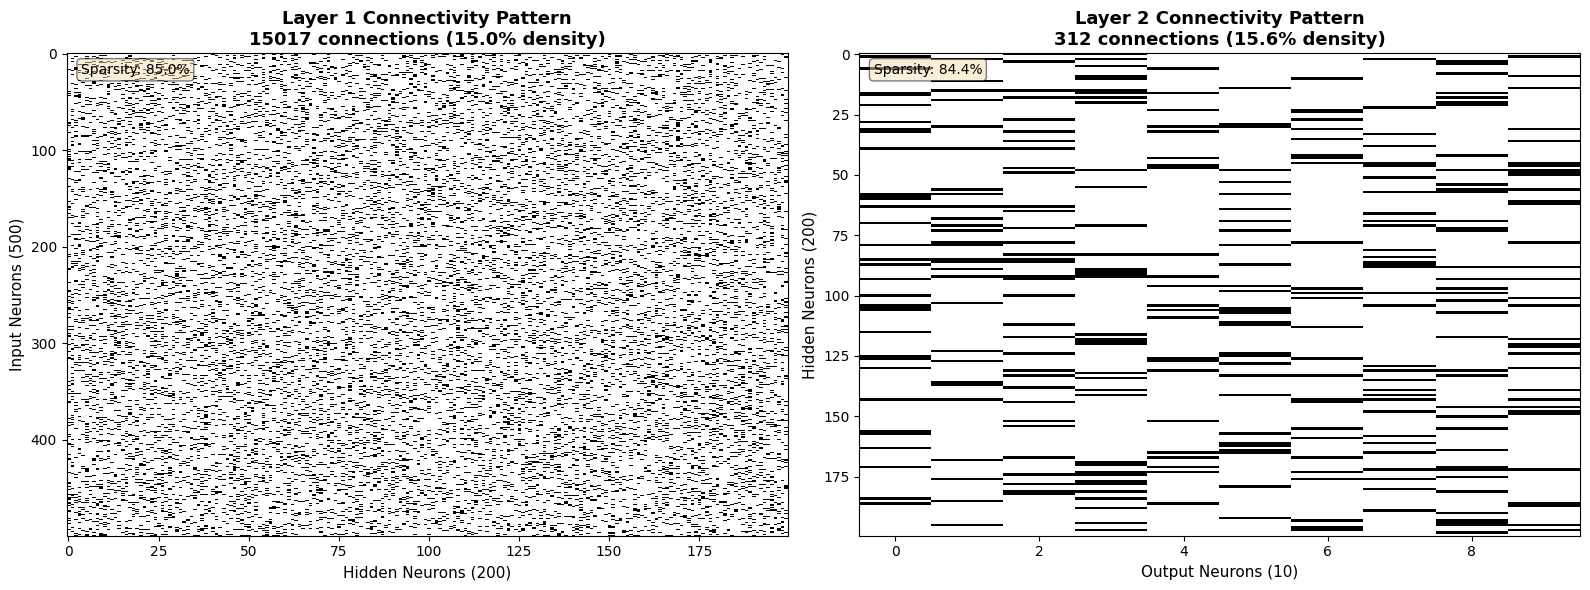


Connection pattern analysis:
  Layer 1: 15,017 connections, 84.98% sparse
  Layer 2: 312 connections, 84.40% sparse
  Total parameters: 15,329
  Saved memory vs dense: 85.0%

Legend: Black = connected, White = not connected


In [13]:
import matplotlib.pyplot as plt

# Extract dense form of weight matrices
w1_dense = network.w1.todense()
w2_dense = network.w2.todense()

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First layer weight connection pattern
w1_binary = np.array(w1_dense != 0, dtype=int)
im1 = axes[0].imshow(w1_binary, aspect='auto', cmap='binary', interpolation='nearest')
axes[0].set_title(f'Layer 1 Connectivity Pattern\n{network.w1.nse} connections ({network.w1.nse/(500*200)*100:.1f}% density)',
                 fontsize=13, fontweight='bold')
axes[0].set_xlabel('Hidden Neurons (200)', fontsize=11)
axes[0].set_ylabel('Input Neurons (500)', fontsize=11)
axes[0].grid(False)

# Add sparsity statistics
sparsity1 = 100 - (network.w1.nse / (500 * 200) * 100)
axes[0].text(0.02, 0.98, f'Sparsity: {sparsity1:.1f}%',
            transform=axes[0].transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Second layer weight connection pattern
w2_binary = np.array(w2_dense != 0, dtype=int)
im2 = axes[1].imshow(w2_binary, aspect='auto', cmap='binary', interpolation='nearest')
axes[1].set_title(f'Layer 2 Connectivity Pattern\n{network.w2.nse} connections ({network.w2.nse/(200*10)*100:.1f}% density)',
                 fontsize=13, fontweight='bold')
axes[1].set_xlabel('Output Neurons (10)', fontsize=11)
axes[1].set_ylabel('Hidden Neurons (200)', fontsize=11)
axes[1].grid(False)

# Add sparsity statistics
sparsity2 = 100 - (network.w2.nse / (200 * 10) * 100)
axes[1].text(0.02, 0.98, f'Sparsity: {sparsity2:.1f}%',
            transform=axes[1].transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print connection statistics
print(f"\nConnection pattern analysis:")
print(f"  Layer 1: {network.w1.nse:,} connections, {sparsity1:.2f}% sparse")
print(f"  Layer 2: {network.w2.nse:,} connections, {sparsity2:.2f}% sparse")
print(f"  Total parameters: {network.w1.nse + network.w2.nse:,}")
print(f"  Saved memory vs dense: {((500*200 + 200*10) - (network.w1.nse + network.w2.nse)) / (500*200 + 200*10) * 100:.1f}%")
print(f"\nLegend: Black = connected, White = not connected")

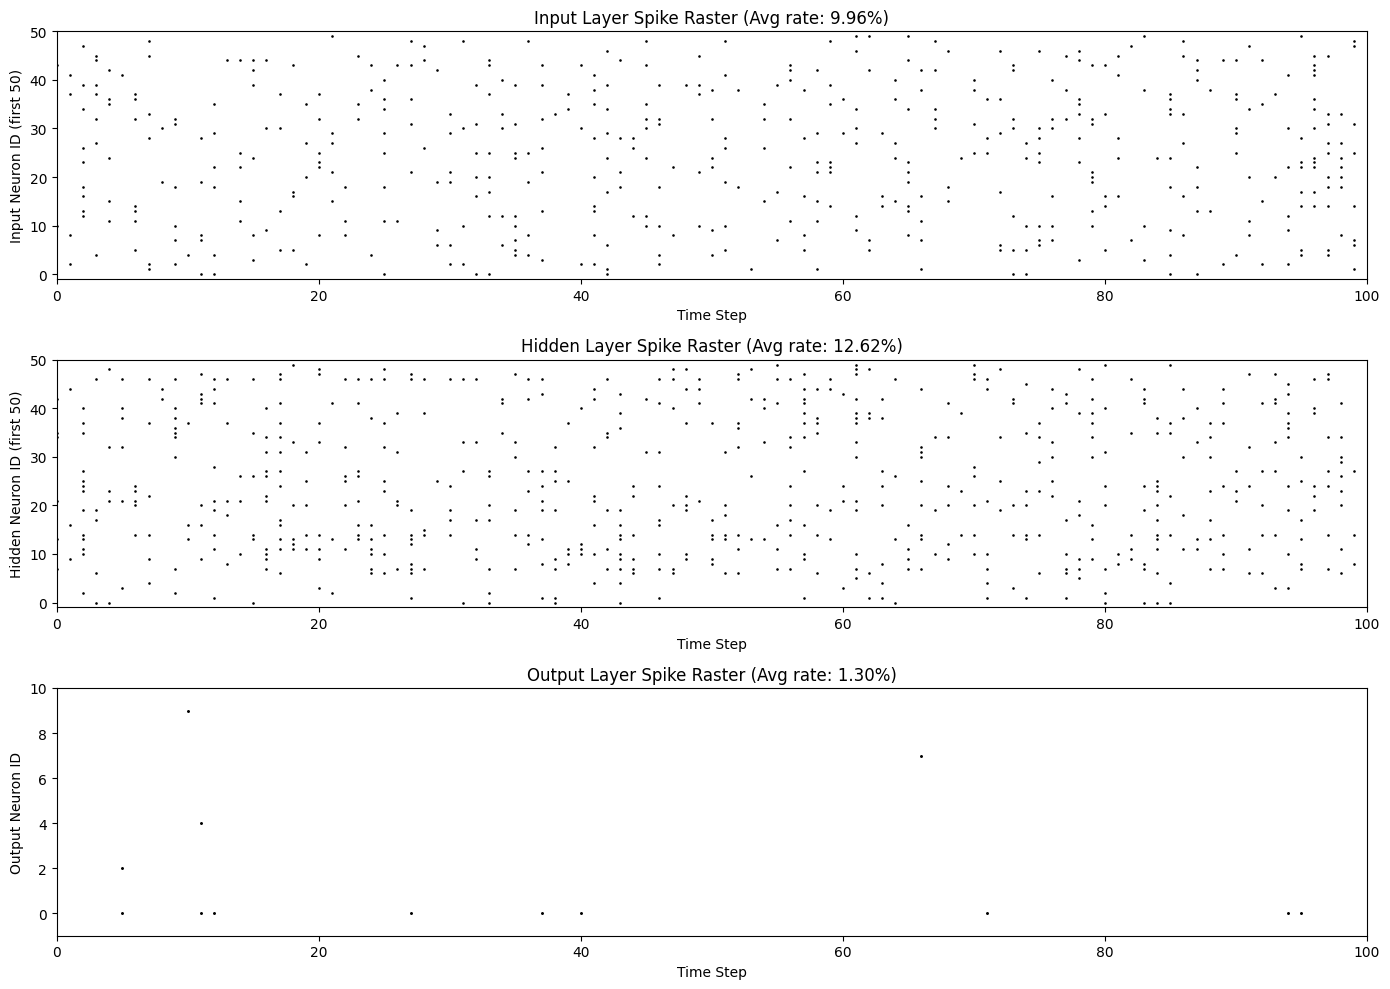


Spike statistics:
  Input layer: 498 spikes over 100 timesteps
  Hidden layer: 631 spikes over 100 timesteps
  Output layer: 13 spikes over 100 timesteps


In [14]:
# Record spike activity over multiple time steps
n_timesteps = 100
spike_history_input = []
spike_history_hidden = []
spike_history_output = []

brainstate.random.seed(888)
for t in range(n_timesteps):
    # Generate input spikes
    input_pattern = brainstate.random.bernoulli(0.1, size=(500,))
    input_spikes = brainevent.EventArray(input_pattern)

    # Forward propagation
    output_act, output_spk, hidden_spk = network.forward(input_spikes)

    # Record first 50 neurons' activity (for visualization)
    spike_history_input.append(np.array(input_pattern[:50], dtype=int))
    spike_history_hidden.append(np.array(hidden_spk.value[:50], dtype=int))
    spike_history_output.append(np.array(output_spk.value, dtype=int))

# Convert to time×neuron matrix
spike_matrix_input = np.array(spike_history_input)  # (100, 50)
spike_matrix_hidden = np.array(spike_history_hidden)  # (100, 50)
spike_matrix_output = np.array(spike_history_output)  # (100, 10)

# Use braintools.visualize.raster_plot to plot spike raster
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Input layer spikes
ts = np.arange(n_timesteps)
ax = plt.subplot(3, 1, 1)
braintools.visualize.raster_plot(
    ts,
    spike_matrix_input,
    markersize=3,
    ax=ax,
    xlim=(0, n_timesteps),
    ylim=(-1, 50),
    xlabel='Time Step',
    ylabel='Input Neuron ID (first 50)',
    title=f'Input Layer Spike Raster (Avg rate: {spike_matrix_input.mean():.2%})',
    show=False
)

# Hidden layer spikes
ax = plt.subplot(3, 1, 2)
braintools.visualize.raster_plot(
    ts,
    spike_matrix_hidden,
    markersize=3,
    ax=ax,
    xlim=(0, n_timesteps),
    ylim=(-1, 50),
    xlabel='Time Step',
    ylabel='Hidden Neuron ID (first 50)',
    title=f'Hidden Layer Spike Raster (Avg rate: {spike_matrix_hidden.mean():.2%})',
    show=False
)

# Output layer spikes
ax = plt.subplot(3, 1, 3)
braintools.visualize.raster_plot(
    ts,
    spike_matrix_output,
    markersize=5,
    ax=ax,
    xlim=(0, n_timesteps),
    ylim=(-1, 10),
    xlabel='Time Step',
    ylabel='Output Neuron ID',
    title=f'Output Layer Spike Raster (Avg rate: {spike_matrix_output.mean():.2%})',
    show=False
)

plt.tight_layout()
plt.show()

print(f"\nSpike statistics:")
print(f"  Input layer: {spike_matrix_input.sum()} spikes over {n_timesteps} timesteps")
print(f"  Hidden layer: {spike_matrix_hidden.sum()} spikes over {n_timesteps} timesteps")
print(f"  Output layer: {spike_matrix_output.sum()} spikes over {n_timesteps} timesteps")

## 8. Format selection guide

### When to use COO?
- ✅ Building phase (flexible element addition)
- ✅ Frequent matrix modifications needed
- ✅ Intermediate step for conversion to other formats

### When to use CSR?
- ✅ **Matrix-vector multiplication** (most common!)
- ✅ Row-wise data access
- ✅ Spiking neural network forward propagation
- ✅ EventArray @ CSR operations

### When to use CSC?
- ✅ Column-wise data access
- ✅ Certain special algorithms (e.g., solving linear systems)
- ✅ Efficient column slicing operations needed

**Recommendation**: For most spiking neural network applications, use **CSR format** combined with **EventArray**!

## 9. Summary

In this tutorial, we learned:

1. ✅ **Necessity of sparse matrices**: Memory and computational efficiency
2. ✅ **Three formats**: Principles and characteristics of COO, CSR, CSC
3. ✅ **Creation and usage**: How to create and operate sparse matrices
4. ✅ **Combination with EventArray**: Dual optimization strategy
5. ✅ **Performance comparison**: Actual performance advantages of sparse matrices
6. ✅ **Practical application**: Building a sparse connection spiking neural network
7. ✅ **Visualization**: Visualizing sparse structures with braintools and matplotlib
8. ✅ **Format selection**: Choosing the appropriate format based on application scenarios

## Next Steps

In the next tutorial, we will learn:
- 📚 **Tutorial 3**: JIT connection matrices - JITCHomoR, JITCNormalR, JITCUniformR
- Learn about just-in-time compiled connection structures without pre-storing weight matrices
- Suitable for ultra-large-scale network modeling